# Explor Multivalue LSMTree

In [317]:
import os.path
import json
import re
from glob import glob
from collections import defaultdict
import base64
import struct

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from cycler import cycler
import pandas as pd
import seaborn as sns
import csaps
import tdigest
from tqdm import tqdm
from tdigest import TDigest

from tdigest_java import read_tdigest

tqdm.pandas()

plt.style.use(['fivethirtyeight'])
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 400)
pd.set_option('display.max_colwidth', 100)

colors = ['#008fd5', '#fc4f30', '#e5ae38', '#6d904f', '#8b8b8b', '#810f7c', '#cc6600', '#cc3399', '#00cc66']
plt.rcParams['axes.prop_cycle'] = cycler(color=colors)

# Constants

In [299]:
type(plt.rcParams['axes.prop_cycle'])

cycler.Cycler

In [12]:
background_color = '#fcfcfc'
old_background_color = plt.rcParams['axes.edgecolor']
for k,v in plt.rcParams.items():
    if v == old_background_color:
        plt.rcParams[k] = background_color

In [85]:
results_base_dir = 'results/mv_doc'
!ls $results_base_dir

author_count.txt  get  load  subreddit_count.txt


In [228]:
intermediate_base_dir = 'intermeidate/mv_doc'
!mkdir -p $intermediate_base_dir

In [86]:
figdir = 'figures/mv_doc'
!rm -r $figdir
!mkdir -p $figdir

# Utilities

In [13]:
def read_results(directory, name_attr_extractor):
    results = []
    for path in glob(results_base_dir + '/' + directory + '/*.jsonl'):
        attrs = name_attr_extractor(os.path.splitext(os.path.basename(path))[0])
        x = pd.read_json(path, lines=True)
        x['time'] = (x['time'] - x['time'].iloc[0]) / 1e9
        attrs['results'] = x
        results.append(attrs)
    return pd.DataFrame(results)

In [14]:
def add_bar_values(ax, x, offset=2):
    for i, v in enumerate(x):
        ax.text(v + offset, i, f'{v:.1f}',
                verticalalignment='center',
                bbox=dict(facecolor=background_color, alpha=1))

In [15]:
def min_duration(df):
    return df.loc[df['duration'].idxmin()]

In [16]:
def compute_rate(results, y_label, dy_dt_label=None, rate=1):
    def row_rate(row):
        row = row.copy()
        x = row['results'][::rate]
        t = np.array(x['time'])
        dt = t[1::] - t[:-1:]
        y = np.array(x[y_label])
        dy = y[1::] - y[:-1:]
        dy_dt = dy/dt
        row['results'] = pd.concat([pd.Series(t[1::]).rename('time'),
                                    pd.Series(dy_dt).rename(dy_dt_label or y_label)], axis=1)
        return row
    return results.apply(row_rate, axis=1)

In [17]:
def time_plot(results, y_col, label_func, t_scale=1.0/60.0, y_scale=1, rate=1, ax=None, spline=True):
    if ax is None:
        fig = plt.figure(figsize=(9,7))
        ax = fig.add_subplot(111)
    for color,(index, row) in zip(colors, results.iterrows()):
        x = row['results'].iloc[1::rate]
        t = x['time'] * t_scale
        y = x[y_col] * y_scale
        if spline:
            ax.plot(t, y, 'o', color=color, alpha=0.3, ms=8, zorder=1, mec='k')
            ts = np.linspace(t.min(), t.max(), 200)
            ys = csaps.csaps(t, y, ts, smooth=0.9)
            ax.plot(ts, ys, '-', color=color, lw=10, alpha=0.75, zorder=2, label=label_func(index, row))
            ax.plot(ts, ys, '-', color='k', lw=1, alpha=1, zorder=3)
        else:
            ax.plot(t, y, 'o', color=color, alpha=0.7, ms=8, zorder=1,
                    label=label_func(index, row))
            ax.plot(t, y, '-', color='k', lw=1, alpha=1, zorder=3)



In [339]:
def format_number(n, wrap=True):
    if isinstance(n, int) and n < 1000:
        ns = str(n)
    elif 1e-1 < n < 1e2:
        ns = f'{n:.2f}'
    else:
        p = int(np.floor(np.log10(n)))
        base = n / 10**p
        ns = f'{base:.2f}\\times 10^{{{p}}}'
    return f'${ns}$' if wrap else ns

In [340]:
def compute_centroids(tdigest):
    centroids = pd.DataFrame(tdigest.centroids_to_list())
    centroids['cum_frac'] = centroids['c'].cumsum() / centroids['c'].sum()
    return centroids

def plot_centroids_cdf(centroids, name, ax, **kwds):
    n = int(centroids["c"].sum())
    m = centroids['m'][centroids['cum_frac'] >= 0.5].iloc[0]
    centroids.plot('m', 'cum_frac', ax=ax,
                   label=f'{name:10} ({format_number(n)}, {format_number(m)})', **kwds)

In [18]:
def savefig(name, fig=None):
    (fig or plt.gcf()).savefig(f'{figdir}/{name}.png', bbox_inches='tight')

In [246]:
def tdigest_merge(t_digests):
    first = t_digests[0]
    merged = TDigest(first.delta, first.K)
    for t_digest in t_digests:
        for c in t_digest.C.values():
            merged.update(c.mean, c.count)
    return merged

# Analyzing Keys

In [139]:
key_counts = pd.read_csv(results_base_dir + '/author_count.txt', sep='=', names=['key', 'count'], header=None)
key_counts = key_counts.sort_values('count', ascending=True).reset_index().drop(['index'], axis=1)
key_counts.tail()

,key,count
7044843,transcribot,87577
7044844,Edgar_The_Pug_Bot,194661
7044845,KeepingDankMemesDank,206701
7044846,AutoModerator,2059516
7044847,[deleted],13984910


In [140]:
entries = key_counts['count'].sum()
f'{entries:.2e}'

'1.47e+08'

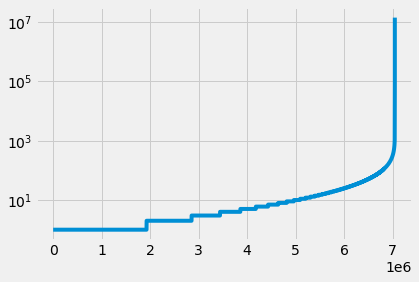

In [141]:
key_counts['count'].plot(kind='line')
plt.yscale('log')

In [142]:
(key_counts['count']
 .describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 0.999])
 .drop(['mean', 'std'])
 .astype(int)
 .map('{:,}'.format)
 .to_frame().T)

,count,min,25%,50%,75%,90%,95%,99%,99.9%,max
count,"7,044,848",1,1,4,12,39,77,246,747,"13,984,910"


In [143]:
key_count_counts = key_counts['count'].value_counts().to_frame().sort_index().reset_index().rename(columns={'index':'key_count'})
key_count_counts.sample(5)

,key_count,count
1429,1437,6
663,664,37
1546,1565,2
608,609,38
2142,3415,1


In [144]:
key_count_counts['cum_frac'] = key_count_counts['count'].cumsum() / key_count_counts['count'].sum()

In [145]:
key_count_counts['cum_perc'] = key_count_counts['cum_frac'] * 100

In [146]:
key_count_counts.tail()

,key_count,count,cum_frac,cum_perc
2304,87577,1,0.999999,99.999943
2305,194661,1,1.000000,99.999957
2306,206701,1,1.000000,99.999972
2307,2059516,1,1.000000,99.999986
2308,13984910,1,1.000000,100.000000


In [147]:
percentiles = pd.DataFrame([{'percentile':round(100*f, 1),
                             'key_count': key_count_counts['key_count'][key_count_counts['cum_frac'] >= f].iloc[0]}
                           for f in [0, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 0.999, 1.0]]
                            )

perc_show = percentiles.copy().rename(
    columns={'key_count': 'Entries per a Key', 'percentile': 'Percentile %'}).set_index('Percentile %')
perc_show['Entries per a Key'] = perc_show['Entries per a Key'].map('{:,}'.format)
perc_show = perc_show.T
print(' '.join(perc_show.to_html(index=True).split()))

perc_show

<table border="1" class="dataframe"> <thead> <tr style="text-align: right;"> <th>Percentile %</th> <th>0.0</th> <th>25.0</th> <th>50.0</th> <th>75.0</th> <th>90.0</th> <th>95.0</th> <th>99.0</th> <th>99.9</th> <th>100.0</th> </tr> </thead> <tbody> <tr> <th>Entries per a Key</th> <td>1</td> <td>1</td> <td>4</td> <td>12</td> <td>39</td> <td>77</td> <td>246</td> <td>747</td> <td>13,984,910</td> </tr> </tbody> </table>


Percentile %,0.0,25.0,50.0,75.0,90.0,95.0,99.0,99.9,100.0
Entries per a Key,1,1,4,12,39,77,246,747,"13,984,910"


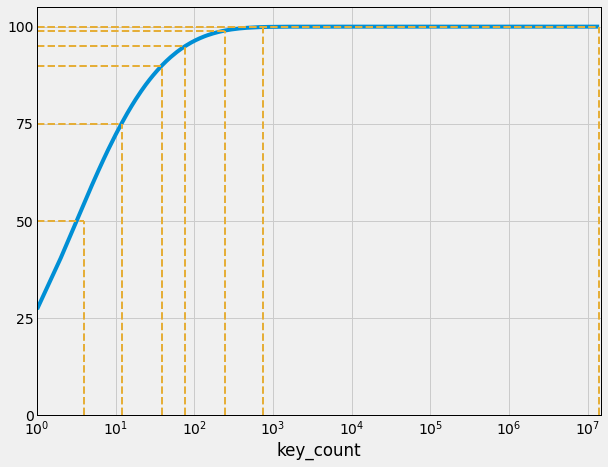

In [148]:

def plot_dist(ax, ll):
    ll.plot('key_count', 'cum_perc', style='-', ax=ax)
    for _,row in percentiles.iterrows():
        if row['key_count'] <= ll['key_count'].max():
            ax.plot([ll['key_count'].min(), row['key_count']],
                    [row['percentile'], row['percentile']],
                '--', color=colors[2], lw=2)
            
            ax.plot([row['key_count'], row['key_count']],
                    [0, row['percentile']],
                '--', color=colors[2], lw=2)
    
    ax.get_legend().remove()
    ax.set_yticks(np.arange(0, 101, 25))


with plt.rc_context({'axes.edgecolor':'k', 'axes.linewidth':1}):
    fig = plt.figure(figsize=(9,7))
    ax = fig.add_subplot(111)
    plot_dist(ax, key_count_counts)
    ax.set_xscale('log')
    ax.set_ylim(0, 105)
    ax.set_xlim(key_count_counts['key_count'].min(), 1.05 * key_count_counts['key_count'].max())

    #ax.set_title(f'Disitribution of JSON Length for {entries/1e6:.1f} Million Reddit Comments')
    #ax.set_xlabel('Comment JSON Length (Bytes)')
    #ax.set_ylabel('Cummulative Fraction')

    if 0:

        axins = ax.inset_axes([0.2, 0.2, 0.75, 0.5])
        plot_dist(axins, key_count_counts[key_count_counts['key_count'] < 1500])
        axins.set_ylim(0, 92)
        axins.set_xlim(key_count_counts['key_count'].min(), 1500)

        axins.set_xlabel('')
        ax.indicate_inset_zoom(axins, edgecolor='k', lw=2, ls=':')

#savefig('reddit_comment_json_len_dist')

# Analyzing Loading

In [82]:
def extract_load_attrs(name):
    key_attr, value_attr, *rest = name.split('_')
    index_rate, partitions, threads = map(int,rest)
    return {'key_attr': key_attr, 'value_attr': value_attr, 'index_rate': index_rate,
            'partitions':partitions, 'threads':threads}

load_results = read_results('load', extract_load_attrs)
load_results.sample(5)

,key_attr,value_attr,index_rate,partitions,threads,results
42,subreddit,id,10,8,4,time writes size 0 0.000000 725466 0 1 1.051645 ...
26,subreddit,id,5,1,4,time writes size 0 0.000000 582526 0 1 1.062201 ...
1,author,id,5,4,8,time writes size 0 0.000000 677164 0 1 1.064836 ...
40,subreddit,id,10,2,2,time writes size 0 0.000000 704936 0 1 1.080150 ...
51,author,id,10,1,2,time writes size 0 0.000000 615021 0 1 1.047902 ...


,count,mean,std,min,25%,50%,75%,max
duration,58.0,3.959267,0.582726,2.713922,3.587866,3.873633,4.220431,5.255999


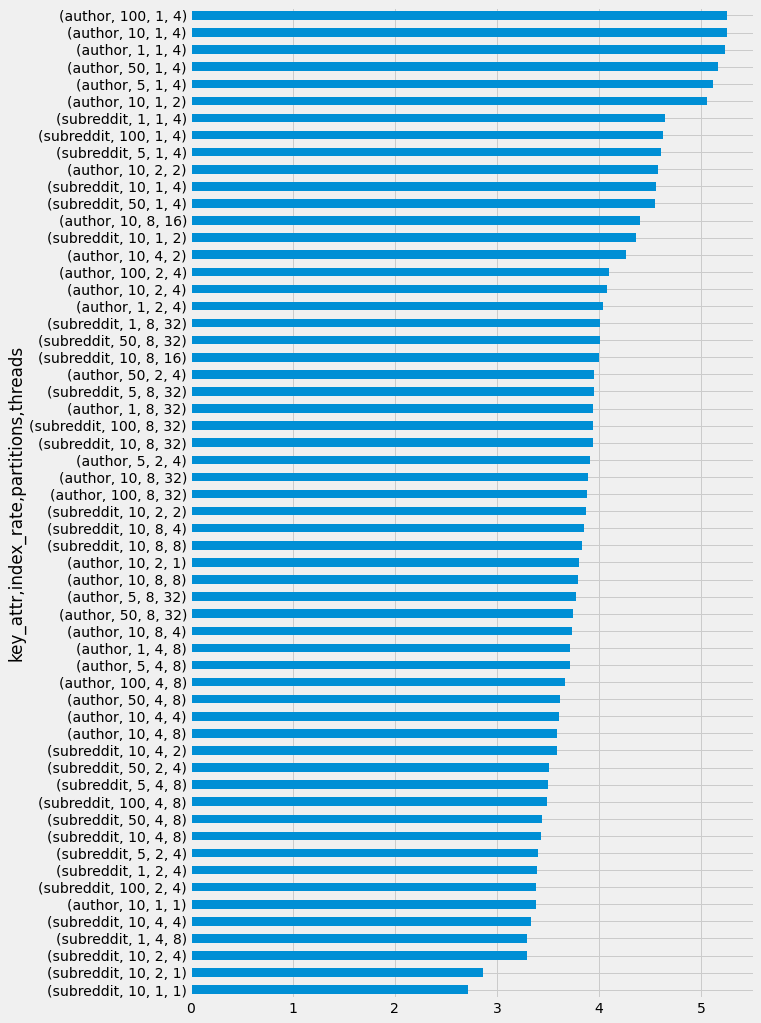

In [177]:
load_results['duration'] = load_results['results'].map(lambda x: x['time'].iloc[-1] - x['time'].iloc[0])
display(load_results['duration'].div(60).describe().to_frame().T)
(load_results
 .set_index(['key_attr', 'index_rate', 'partitions', 'threads'])
 ['duration'].div(60).sort_values()
 .plot.barh(figsize=(9,17)))

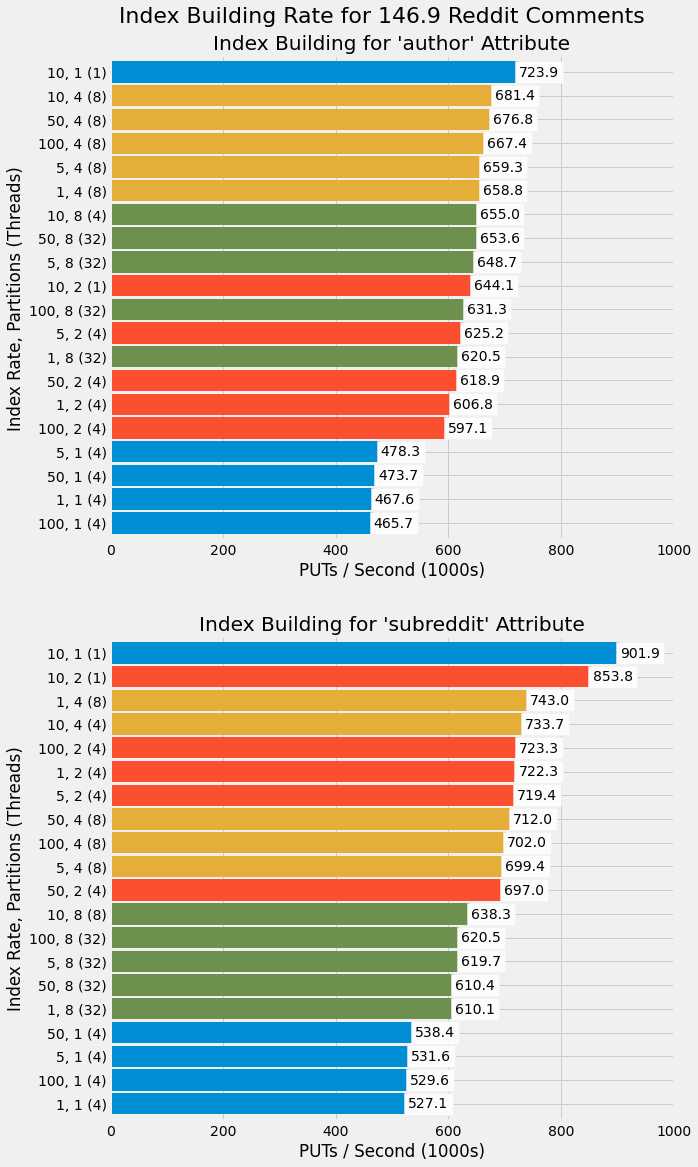

In [174]:
load_results['rate'] = entries / load_results['duration']
fig = plt.figure(figsize=(9,17))

for i,(key_attr, df) in enumerate(load_results.groupby('key_attr')):
    df = (df.groupby(['index_rate', 'partitions'])
          .apply(lambda g: min_duration(g).drop(['index_rate', 'partitions']))
          .sort_values('rate'))
    x = df['rate'].div(1000)
    p = df.reset_index()['partitions']
    ax = fig.add_subplot(2, 1, 1 + i)
    x.plot.barh(color=p.map(dict(zip(sorted(set(p)), colors))), ax=ax, width=0.9)
    add_bar_values(ax, x)
    ax.set_yticklabels(df.reset_index().apply(
        (lambda r: f'{r["index_rate"]}, {r["partitions"]} ({r["threads"]})'), axis=1))
    ax.set_ylabel('Index Rate, Partitions (Threads)')
    ax.set_xlabel('PUTs / Second (1000s)')
    ax.set_title(f"Index Building for '{key_attr}' Attribute")
    ax.set_xlim(0, 1000)
fig.suptitle(f'Index Building Rate for {entries/1e6:.1f} Reddit Comments', size=22)
fig.subplots_adjust(top=0.94)
#savefig('doc_load_rate')

In [351]:
load_partition_min_duration = (
    load_results.groupby(['key_attr', 'index_rate', 'partitions'])
    .apply(min_duration)
    .drop(['key_attr', 'index_rate', 'partitions'], axis=1)
)
load_partition_min_duration

value_attr  threads                                                                                              results    duration           rate
key_attr  index_rate partitions                                                                                                                                                    
author    1          1                  id        4             time     writes        size
0      0.000000     588265           0
1      1.047740   ...  314.047159  467618.903750
                     2                  id        4             time     writes        size
0      0.000000     729904           0
1      1.066438   ...  242.028744  606764.244370
                     4                  id        8             time     writes        size
0      0.000000     678166           0
1      1.047545   ...  222.912317  658798.893276
                     8                  id       32             time     writes        size
0      0.000000     558504           0
1      1.051380   ...  236.687220  620457.613706
          5          1                  id        4             time     writes        size
0      0.000000     573488           0
1      1.047887   ...  307.020198  478321.585195
                     2                  id        4             time     writes        size
0      0.000000     725170           0
1      1.051121   ...  234.876377  625241.200970
                     4                  id        8             time     writes        size
0      0.000000     677164           0
1      1.064836   ...  222.741206  659304.988409
                     8                  id       32             time     writes        size
0      0.000000     605242           0
1      1.051227   ...  226.370715  648734.037403
          10         1                  id        1             time     writes        size
0      0.000000     845974           0
1      1.058758   ...  202.869837  723884.784849
                     2                  id        1             time     writes        size
0      0.000000     818365           0
1      1.047541   ...  228.000980  644095.424751
                     4                  id        8             time     writes        size
0      0.000000     693923           0
1      1.056798   ...  215.508463  681432.117381
                     8                  id        4             time     writes        size
0      0.000000     617888           0
1      1.067265   ...  224.200758  655012.897888
          50         1                  id        4             time     writes        size
0      0.000000     584933           0
1      1.047144   ...  310.023589  473687.788023
                     2                  id        4             time     writes        size
0      0.000000     709500           0
1      1.047641   ...  237.300092  618855.167654
                     4                  id        8             time     writes        size
0      0.000000     655283           0
1      1.080788   ...  216.991492  676774.865093
                     8                  id       32             time     writes        size
0      0.000000     603599           0
1      1.062544   ...  224.688482  653591.080950
          100        1                  id        4             time     writes        size
0      0.000000     605760           0
1      1.046787   ...  315.359944  465672.292003
                     2                  id        4             time     writes        size
0      0.000000     699836           0
1      1.047964   ...  245.965937  597051.729795
                     4                  id        8             time     writes        size
0      0.000000     661249           0
1      1.065580   ...  220.037184  667407.140791
                     8                  id       32             time     writes        size
0      0.000000     549270           0
1      1.065755   ...  232.637668  631257.995507
subreddit 1          1                  id        4             time    

Text(0.5, 1.0, 'Time Dependence of Index Building\nfor 146.9 Million Reddit Comments')

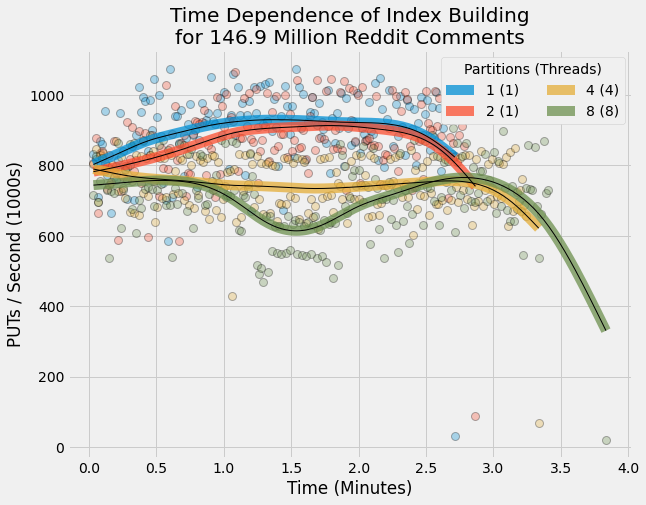

In [358]:
time_plot(compute_rate(load_partition_min_duration.loc['subreddit', 10], 'writes'), 
          y_col='writes', y_scale=1e-3,
          label_func=lambda partitions, row: f'{partitions} ({row["threads"]})')

plt.ylabel('PUTs / Second (1000s)')
plt.legend(loc='upper right', ncol=2, title='Partitions (Threads)', framealpha=1)
plt.xlabel('Time (Minutes)')
plt.title(f'Time Dependence of Index Building\nfor {entries/1e6:.1f} Million Reddit Comments')
#savefig('doc_load_time_dependence')

Text(0.5, 1.0, 'Time Dependence of Index Building\nfor 146.9 Million Reddit Comments')

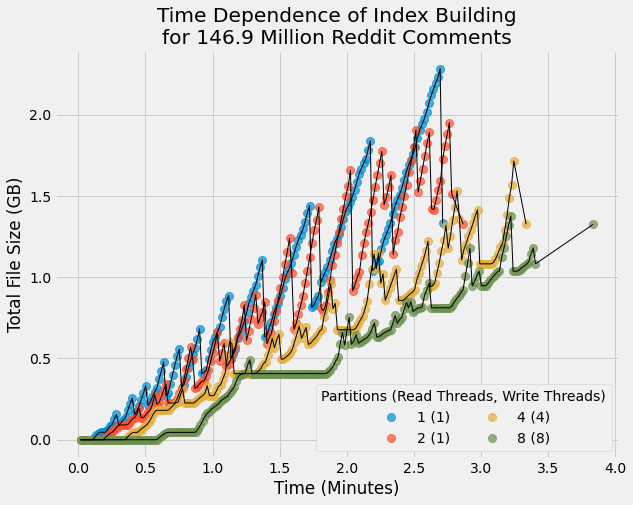

In [360]:
time_plot(load_partition_min_duration.loc['subreddit', 10],
          y_col='size', y_scale=1e-9, spline=False,
          label_func=lambda partitions, row: f'{partitions} ({row["threads"]})')

plt.ylabel('Total File Size (GB)')
plt.legend(loc='lower right', ncol=2, title='Partitions (Read Threads, Write Threads)', framealpha=1)
plt.xlabel('Time (Minutes)')
plt.title(f'Time Dependence of Index Building\nfor {entries/1e6:.1f} Million Reddit Comments')
#savefig('doc_load_time_dependence_size')

In [362]:
load_partition_min_duration.loc['subreddit', ::, 1]

value_attr  threads                                                                                              results    duration           rate
key_attr  index_rate partitions                                                                                                                                                    
subreddit 1          1                  id        4             time     writes        size
0      0.000000     591631           0
1      1.064001   ...  278.609731  527097.124086
          5          1                  id        4             time     writes        size
0      0.000000     582526           0
1      1.062201   ...  276.244652  531609.885446
          10         1                  id        1             time     writes        size
0      0.000000     802991           0
1      1.047653   ...  162.835297  901858.446276
          50         1                  id        4             time     writes        size
0      0.000000     560206           0
1      1.059694   ...  272.741347  538438.302226
          100        1                  id        4             time     writes        size
0      0.000000     538179           0
1      1.072674   ...  277.281457  529622.101065

Text(0.5, 1.0, 'Time Dependence of Index Building\nfor 146.9 Million Reddit Comments')

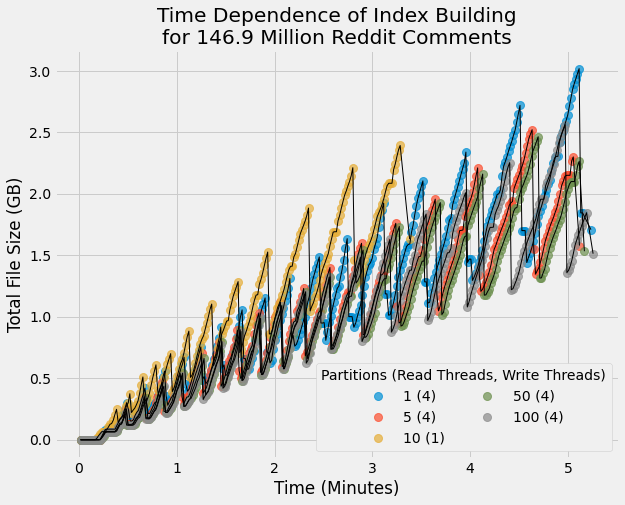

In [365]:
time_plot(load_partition_min_duration.loc['author', ::, 1].reset_index().set_index('index_rate'),
          y_col='size', y_scale=1e-9, spline=False,
          label_func=lambda index_rate, row: f'{index_rate} ({row["threads"]})')

plt.ylabel('Total File Size (GB)')
plt.legend(loc='lower right', ncol=2, title='Partitions (Read Threads, Write Threads)', framealpha=1)
plt.xlabel('Time (Minutes)')
plt.title(f'Time Dependence of Index Building\nfor {entries/1e6:.1f} Million Reddit Comments')
#savefig('doc_load_time_dependence_size')

# Analyzing Get

In [179]:
!ls $results_base_dir/get

results.jsonl  specs.jsonl


In [236]:
intermediate_get_path = intermediate_base_dir + '/get_results.p'

def convert_stats(stats):
    if not stats:
        return pd.DataFrame([], columns=['floor', 'count', 't_digest'])
    stats = pd.DataFrame(stats)
    if 'tDigtest' in stats.columns:
        stats = stats.rename(columns={'tDigtest':'tDigest'})
    stats['t_digest'] = stats['tDigest'].map(read_tdigest)
    stats = stats.drop(['tDigest'], axis=1)
    return stats[['floor', 'count', 't_digest']]
    
    
def aggregate_results(df):
    df['time'] = (df['nano_time'] - df['nano_time'].min()) / 1e9
    df = df.drop(['nano_time', 'spec_id'], axis=1)
    df = df.sort_values('time')
    df['stats'] = df['stats'].map(convert_stats)
    return pd.Series({
        'results': df,
        'duration': df['time'].iloc[-1],
        'get_keys': df['get_keys'].iloc[-1],
        'get_values': df['get_values'].iloc[-1],
        'file_size': df['file_size'].iloc[-1]
    })

if 'get_results' in globals():
    print('skipping time consuming loading of get_results since it already exists')
elif os.path.exists(intermediate_get_path):
    print('loading get_results from disk')
    get_results = pd.read_pickle(intermediate_get_path)
else:
    print('computing get_results from raw data. this may take a while')
    get_specs = pd.read_json(results_base_dir + '/get/specs.jsonl', lines=True)
    get_specs = pd.concat([get_specs.drop('spec', axis=1),
                           pd.DataFrame(list(get_specs['spec']), index=get_specs.index)], axis=1)
    print(len(get_specs))
    
    get_results_entries = pd.read_json(results_base_dir + '/get/results.jsonl', lines=True, convert_dates=False)
    print(len(get_results_entries))
    get_results_entries.sample(5)

    get_results = get_results_entries.groupby('spec_id').progress_apply(aggregate_results)
    get_results = pd.concat([get_specs.set_index('id'), get_results], axis=1)

get_results.sample(5)

skipping time consuming loading of get_results since it already exists


,created_at,events,last_modified,status,partitions,duration_seconds,report_frequency_seconds,key_attr,trial_index,index_rate,thread_count,results,duration,get_keys,get_values,get_key_rate,get_value_rate
9a11b17b-9c37-11ea-8269-00155d010301,2020-05-22 14:22:02.355192,"[{'msg': 'starting', 'hostname': 'ec2-54-186-78-161.us-west-2.compute.amazonaws.com', 'time': '2...",2020-05-22T15:22:42.033913,succeeded,8,300,10,author,0,10,8,...,299.999219,85136584,1703073531,283789.352390,5.676927e+06
9dace358-9c37-11ea-8269-00155d010301,2020-05-22 14:22:07.851995,"[{'msg': 'starting', 'hostname': 'ec2-54-218-108-252.us-west-2.compute.amazonaws.com', 'time': '...",2020-05-22T15:47:42.581002,succeeded,8,300,10,subreddit,0,10,16,...,300.373190,26739174,26002048837,89019.842414,8.656581e+07
9b491b14-9c37-11ea-8269-00155d010301,2020-05-22 14:22:03.530692,"[{'msg': 'starting', 'hostname': 'ec2-54-186-78-161.us-west-2.compute.amazonaws.com', 'time': '2...",2020-05-22T16:07:55.538574,succeeded,1,300,10,author,0,1,4,...,299.999031,48178351,1016135124,160595.022144,3.387128e+06
9a11b182-9c37-11ea-8269-00155d010301,2020-05-22 14:22:02.905159,"[{'msg': 'starting', 'hostname': 'ec2-54-190-65-4.us-west-2.compute.amazonaws.com', 'time': '202...",2020-05-22T15:42:22.784450,succeeded,1,300,10,subreddit,0,50,2,...,300.013780,947074,889886889,3156.768334,2.966153e+06
2c4791fd-9c3e-11ea-8269-00155d010301,2020-05-22 15:09:03.392900,"[{'msg': 'starting', 'hostname': 'ec2-34-209-44-21.us-west-2.compute.amazonaws.com', 'time': '20...",2020-05-22T16:38:00.068895,succeeded,1,300,10,author,0,10,80,...,300.094613,183385485,3784169029,611092.225632,1.260992e+07


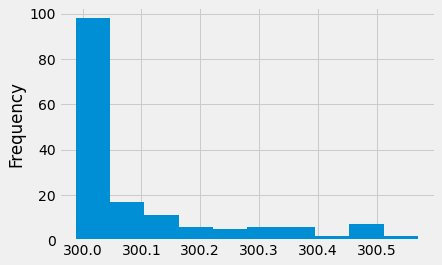

In [218]:
get_results['duration'].plot.hist()

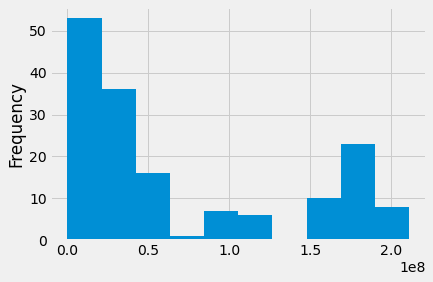

In [219]:
get_results['get_keys'].plot.hist()

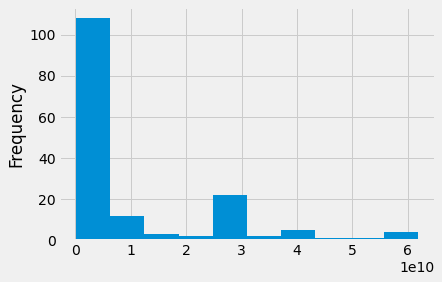

In [220]:
get_results['get_values'].plot.hist()

,count,mean,std,min,25%,50%,75%,max
get_key_rate,160.0,230.539126,238.236827,0.842407,40.01403,103.926443,508.029044,703.454866


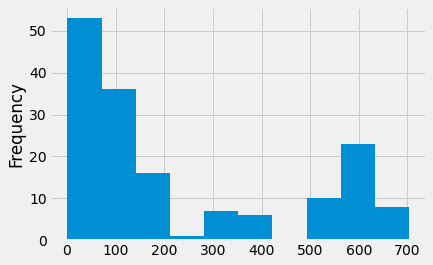

In [227]:
get_results['get_key_rate'] = get_results['get_keys'] / get_results['duration']
display(get_results['get_key_rate'].div(1e3).describe().to_frame().T)
get_results['get_key_rate'].div(1e3).plot.hist()

,count,mean,std,min,25%,50%,75%,max
get_value_rate,160.0,35.758591,47.926021,0.401781,6.318986,12.871413,41.329132,205.671415


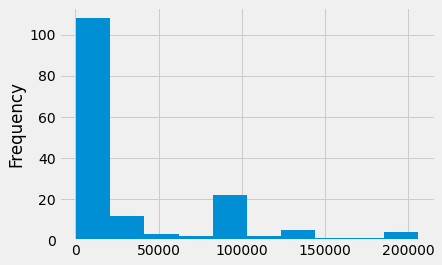

In [226]:
get_results['get_value_rate'] = get_results['get_values'] / get_results['duration']
display(get_results['get_value_rate'].div(1e6).describe().to_frame().T)
get_results['get_value_rate'].div(1e3).plot.hist()

count          mean  std           min           25%           50%           75%           max
key_attr  partitions index_rate                                                                                                
subreddit 1          100          10.0  1.323917e+09  0.0  1.323917e+09  1.323917e+09  1.323917e+09  1.323917e+09  1.323917e+09
                     50           10.0  1.323945e+09  0.0  1.323945e+09  1.323945e+09  1.323945e+09  1.323945e+09  1.323945e+09
          8          10           10.0  1.324152e+09  0.0  1.324152e+09  1.324152e+09  1.324152e+09  1.324152e+09  1.324152e+09
          4          10           10.0  1.324156e+09  0.0  1.324156e+09  1.324156e+09  1.324156e+09  1.324156e+09  1.324156e+09
          2          10           10.0  1.324161e+09  0.0  1.324161e+09  1.324161e+09  1.324161e+09  1.324161e+09  1.324161e+09
          1          10           10.0  1.324165e+09  0.0  1.324165e+09  1.324165e+09  1.324165e+09  1.324165e+09  1.324165e+09
                     5            10.0  1.324441e+09  0.0  1.324441e+09  1.324441e+09  1.324441e+09  1.324441e+09  1.324441e+09
                     1            10.0  1.326648e+09  0.0  1.326648e+09  1.326648e+09  1.326648e+09  1.326648e+09  1.326648e+09
author    1          100          10.0  1.415533e+09  0.0  1.415533e+09  1.415533e+09  1.415533e+09  1.415533e+09  1.415533e+09
                     50           10.0  1.416725e+09  0.0  1.416725e+09  1.416725e+09  1.416725e+09  1.416725e+09  1.416725e+09
          8          10           10.0  1.425694e+09  0.0  1.425694e+09  1.425694e+09  1.425694e+09  1.425694e+09  1.425694e+09
          4          10           10.0  1.425875e+09  0.0  1.425875e+09  1.425875e+09  1.425875e+09  1.425875e+09  1.425875e+09
          2          10           10.0  1.426138e+09  0.0  1.426138e+09  1.426138e+09  1.426138e+09  1.426138e+09  1.426138e+09
          1          10           10.0  1.426274e+09  0.0  1.426274e+09  1.426274e+09  1.426274e+09  1.426274e+09  1.426274e+09
                     5            10.0  1.438207e+09  0.0  1.438207e+09  1.438207e+09  1.438207e+09  1.438207e+09  1.438207e+09
                     1            10.0  1.533700e+09  0.0  1.533700e+09  1.533700e+09  1.533700e+09  1.533700e+09  1.533700e+09

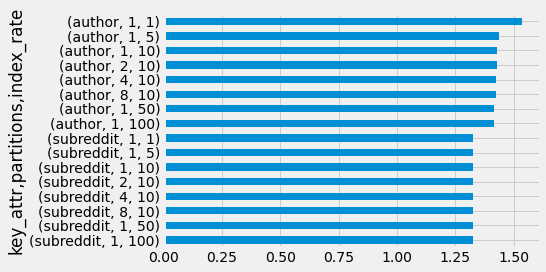

In [385]:

size_stats = (
    get_results
    .groupby(['key_attr', 'partitions', 'index_rate'])
    ['file_size'].describe()
    .sort_values('50%'))
display(size_stats)
size_stats['50%'].div(1e9).plot.barh()

In [386]:
(
    get_results
    .groupby(['key_attr','index_rate'])
    ['file_size'].describe()
    .sort_values('50%'))

count          mean            std           min           25%           50%           75%           max
key_attr  index_rate                                                                                                          
subreddit 100          10.0  1.323917e+09       0.000000  1.323917e+09  1.323917e+09  1.323917e+09  1.323917e+09  1.323917e+09
          50           10.0  1.323945e+09       0.000000  1.323945e+09  1.323945e+09  1.323945e+09  1.323945e+09  1.323945e+09
          10           40.0  1.324159e+09    4807.370750  1.324152e+09  1.324155e+09  1.324159e+09  1.324162e+09  1.324165e+09
          5            10.0  1.324441e+09       0.000000  1.324441e+09  1.324441e+09  1.324441e+09  1.324441e+09  1.324441e+09
          1            10.0  1.326648e+09       0.000000  1.326648e+09  1.326648e+09  1.326648e+09  1.326648e+09  1.326648e+09
author    100          10.0  1.415533e+09       0.000000  1.415533e+09  1.415533e+09  1.415533e+09  1.415533e+09  1.415533e+09
          50           10.0  1.416725e+09       0.000000  1.416725e+09  1.416725e+09  1.416725e+09  1.416725e+09  1.416725e+09
          10           40.0  1.425995e+09  228354.395802  1.425694e+09  1.425830e+09  1.426007e+09  1.426172e+09  1.426274e+09
          5            10.0  1.438207e+09       0.000000  1.438207e+09  1.438207e+09  1.438207e+09  1.438207e+09  1.438207e+09
          1            10.0  1.533700e+09       0.000000  1.533700e+09  1.533700e+09  1.533700e+09  1.533700e+09  1.533700e+09

Text(0.5, 0, 'Concurrent Reading Threads')

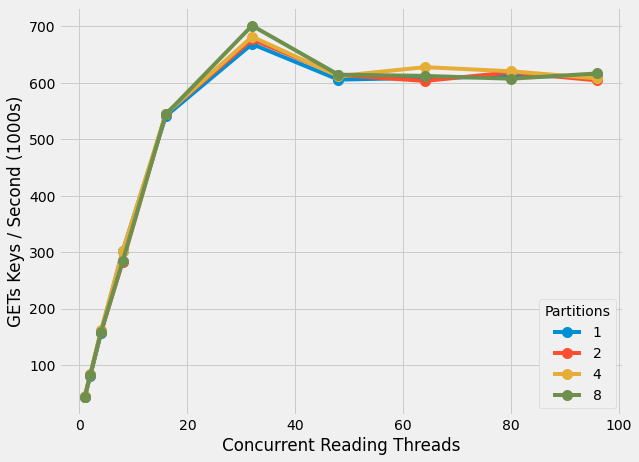

In [337]:
fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(1, 1, 1)
x = get_results[(get_results['index_rate'] == 10) &
                (get_results['key_attr'] == 'author')]
for partitions, x in x.groupby('partitions'):
    x = x.copy()
    x['get_key_rate'] /= 1e3
    x = x.sort_values('thread_count')
    x.plot('thread_count', 'get_key_rate', style='o-', label=str(partitions), ax=ax, ms=10)
#plt.xscale('log')
#plt.xticks(x['threads'], x['threads'])
plt.ylabel('GETs Keys / Second (1000s)')
plt.legend(loc='lower right', ncol=1, title='Partitions', framealpha=1)
plt.xlabel('Concurrent Reading Threads')
#plt.title(f'Fetching Doucments for Three Minutes\nfrom {entries/1e6:.1f} Million Reddit Comments')
#savefig('doc_get_rate')

(-5.0, 100.0)

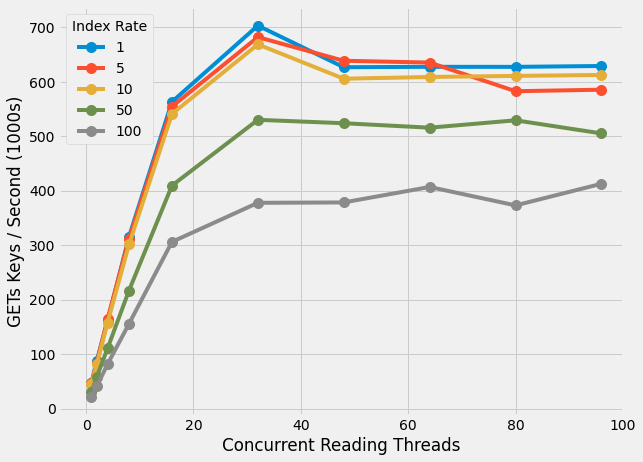

In [336]:
fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(1, 1, 1)
x = get_results[(get_results['partitions'] == 1) &
                (get_results['key_attr'] == 'author')]
for index_rate, x in x.groupby('index_rate'):
    x = x.copy()
    x['get_key_rate'] /= 1e3
    x = x.sort_values('thread_count')
    x.plot('thread_count', 'get_key_rate', style='o-', label=str(index_rate), ax=ax, ms=10)
#plt.xscale('log')
#plt.xticks(x['threads'], x['threads'])
plt.ylabel('GETs Keys / Second (1000s)')
plt.legend(ncol=1, title='Index Rate', framealpha=1)
plt.xlabel('Concurrent Reading Threads')
plt.xlim(-5, 100)
#plt.title(f'Fetching Doucments for Three Minutes\nfrom {entries/1e6:.1f} Million Reddit Comments')
#savefig('doc_get_rate')

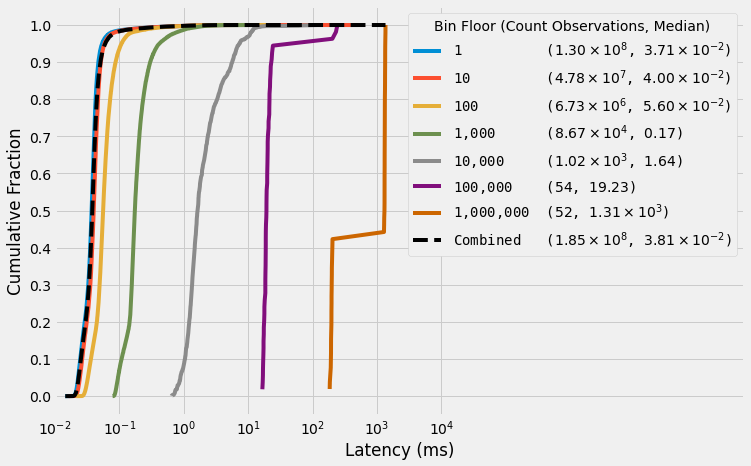

In [321]:
fig = plt.figure(figsize=(11,7))
ax = fig.add_subplot(111)

def combine_stats(stats):
    acc_floor = defaultdict(list)
    for floor_stats in stats:
        if len(floor_stats):
            for _, stat in floor_stats.iterrows():
                acc_floor[stat['floor']].append(stat['t_digest'])
    return pd.DataFrame([{'floor':f, 't_digest': tdigest_merge(tds)}
                         for f, tds in acc_floor.items()])



stats = combine_stats(get_results.iloc[0]['results']['stats'])
for _, row in stats.iterrows():
    plot_centroids_cdf(compute_centroids(row['t_digest']), f'{row["floor"]:,}', ax)

plot_centroids_cdf(compute_centroids(tdigest_merge(stats['t_digest'])), 'Combined', ax, color='k', ls='--')
ax.set_xscale('log')
ax.set_xlabel('Latency (ms)')
ax.set_ylabel('Cumulative Fraction')
ax.set_xlim(1e-2, 5e8)
ax.set_xticks(10 ** np.arange(-2, 4.1, 1.0))
ax.set_yticks(np.arange(0, 1.01, 0.1))
plt.legend(loc='upper right', ncol=1, title='Bin Floor (Count Observations, Median)', framealpha=1,
          prop={'family': 'monospace'})


In [ ]:
def show_stats(index):
    stats = results['stats'].iloc[index]
    fig = plt.figure(figsize=(11,5))
    ax = fig.add_subplot(111)
    for i, (floor, row) in enumerate(stats.iterrows()):
        ax.bar([i], [row.loc[75] - row.loc[25]], width=0.6, bottom=[row.loc[25]])
        ys = [row.loc[10], row.loc[90]]
        ax.plot([i, i], ys, 'k--', lw=2)
        for y in ys:
            ax.plot([i-0.2, i+0.2], [y, y], 'k--', lw=2)
        ax.plot([i-0.3, i+0.3], [row.loc[50], row.loc[50]], 'k-', lw=3)
        for y,m in zip([row.loc[0], row.loc[95], row.loc[99], row.loc[100]],
                       ['o', 's', '>', '*', '^']):
            ax.plot([i], [y], 'k'+m)
    ax.set_ylim(1e-3, 700)
    ax.set_yscale('log')
    yt = list(range(len(stats)))
    ax.set_xticks(yt)
    ax.set_xticklabels([f'{floor:,}\n[{int(row["count"]):,}]' for floor, row in stats.iterrows()])
    ax.set_ylabel('Lookup Time (ms)')
    ax.set_xlabel('Bin Floor (Values), [Lookups Count]')
for i in [1, 3, 6]:
    show_stats(i)

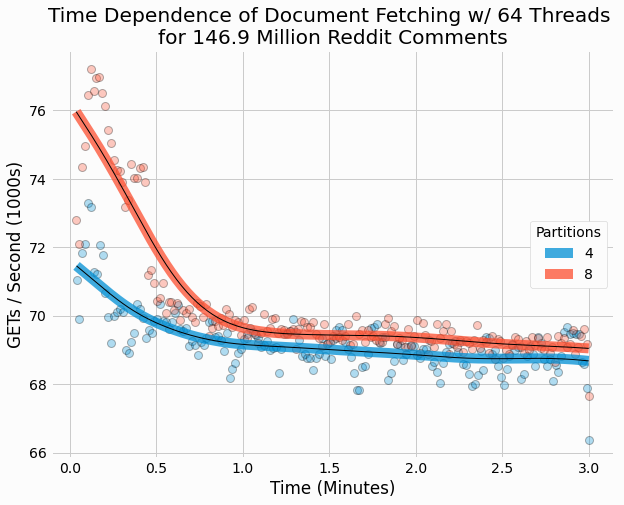

In [30]:
time_plot(compute_rate(get_results[get_results['threads'] == 64], 'gets'), 
          y_col='gets', y_scale=1e-3,
          label_func=lambda ix, row: str(row['partitions']))

plt.ylabel('GETs / Second (1000s)')
plt.legend(loc='center right', ncol=1, title='Partitions', framealpha=1)
plt.xlabel('Time (Minutes)')
plt.title(f'Time Dependence of Document Fetching w/ 64 Threads \nfor {entries/1e6:.1f} Million Reddit Comments')
savefig('doc_get_time_dependence')

# Analyzing Updates

In [31]:
def extract_get_attrs(name):
    partitions, threads = map(int, name.split('_'))
    return {'partitions':partitions, 'threads':threads}

update_results = read_results('update', extract_get_attrs)
update_results.sample(5)

,partitions,threads,results
2,2,80,time updates size 0 0.000000 0 154505206469 1 1.2...
20,8,64,time updates size 0 0.000000 0 154497019784 1 1.2...
6,4,96,time updates size 0 0.000000 0 154498682063 1 1.2...
24,4,8,time updates size 0 0.000000 0 154498682063 1 1.079...
12,2,96,time updates size 0 0.000000 0 154505206469 1 1.2...


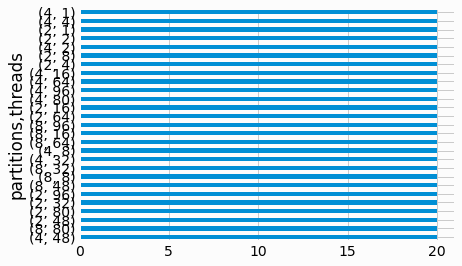

In [32]:
update_results['duration'] = update_results['results'].map(lambda x: x['time'].iloc[-1] - x['time'].iloc[0])
update_results.set_index(['partitions', 'threads'])['duration'].div(60).sort_values(ascending=False).plot.barh()

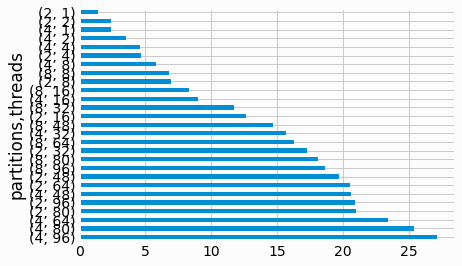

In [33]:
update_results['updates'] = update_results['results'].map(lambda x: x['updates'].iloc[-1])
update_results.set_index(['partitions', 'threads'])['updates'].sort_values(ascending=False).div(1e6).plot.barh()

22.635536270288053

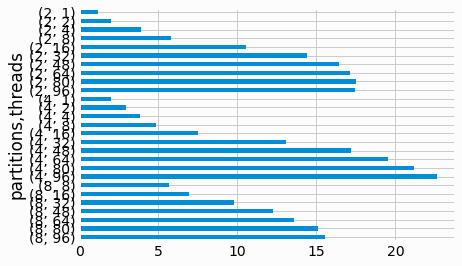

In [34]:
update_results['rate'] = update_results['updates'] / update_results['duration']
update_results.set_index(['partitions', 'threads'])['rate'].sort_index(ascending=False).div(1e3).plot.barh()
update_results.set_index(['partitions', 'threads'])['rate'].max() / 1e3

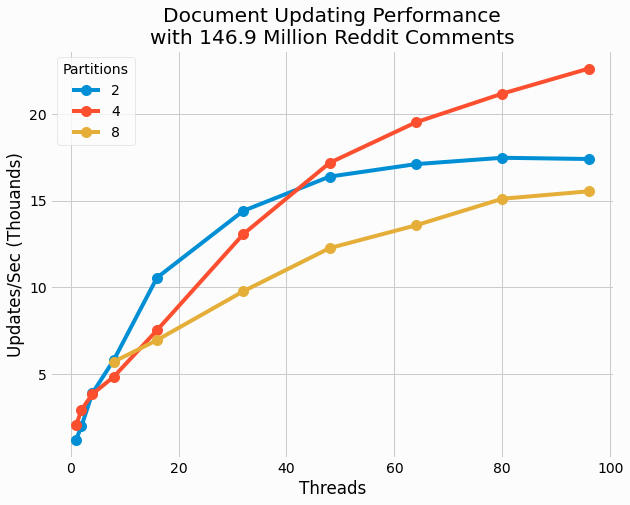

In [35]:
fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(1, 1, 1)
for color,(partitions, x) in zip(colors, update_results.groupby('partitions')):
    x = x.sort_values('threads')
    x['rate'] /= 1000
    x.sort_values('threads').plot('threads', 'rate', style='o-', label=str(partitions), ax=ax, ms=10)

ax.legend(title='Partitions')
ax.set_xlabel('Threads')
ax.set_ylabel('Updates/Sec (Thouands)')
plt.title(f'Document Updating Performance\nwith {entries/1e6:.1f} Million Reddit Comments')
savefig('doc_update_rate')
#plt.xscale('log')
#plt.xticks(x['threads'], x['threads'])

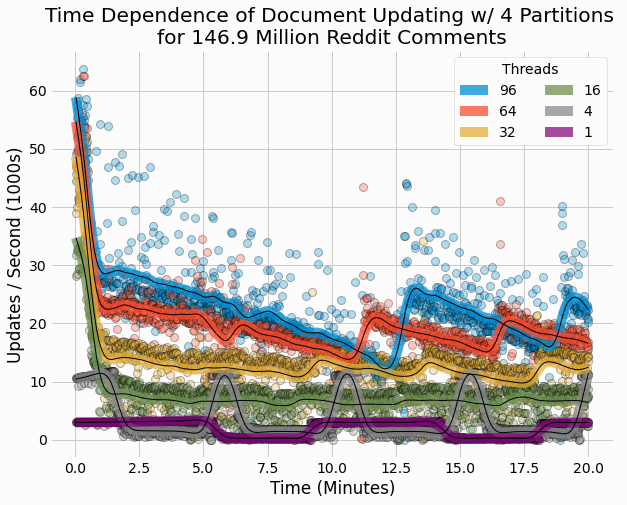

In [36]:
time_plot(compute_rate(update_results[(update_results['threads'].isin([1, 4, 16, 32, 64, 96])) &
                                      (update_results['partitions'] == 4)]
                     .sort_values('threads', ascending=False), 'updates'), 
          y_col='updates', y_scale=1e-3,
          label_func=lambda ix, row: str(row['threads']))

plt.ylabel('Updates / Second (1000s)')
plt.legend(loc='upper right', ncol=2, title='Threads', framealpha=1)
plt.xlabel('Time (Minutes)')
plt.title(f'Time Dependence of Document Updating w/ 4 Partitions \nfor {entries/1e6:.1f} Million Reddit Comments')
savefig('doc_update_time_dependence_threads')


<Figure size 648x504 with 0 Axes>

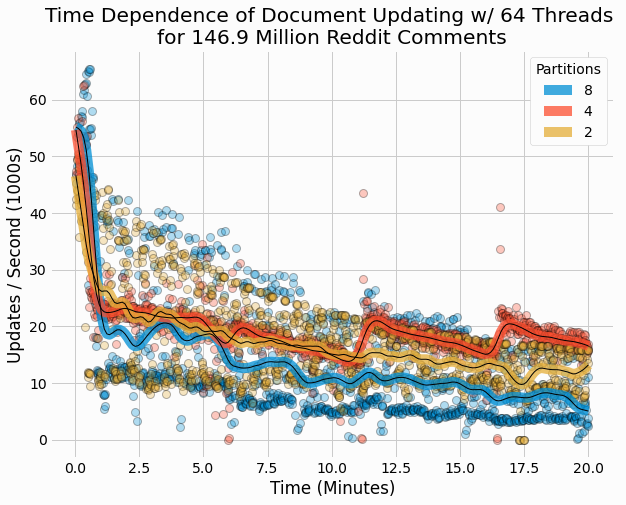

In [37]:
plt.figure(figsize=(9,7))

time_plot(compute_rate(update_results[(update_results['threads'] == 64)]
                       .sort_values('partitions', ascending=False),
                       'updates'), 
          y_col='updates', y_scale=1e-3,
          label_func=lambda ix, row: str(row['partitions']))

plt.ylabel('Updates / Second (1000s)')
plt.legend(loc='upper right', ncol=1, title='Partitions', framealpha=1)
plt.xlabel('Time (Minutes)')
plt.title(f'Time Dependence of Document Updating w/ 64 Threads \nfor {entries/1e6:.1f} Million Reddit Comments')
savefig('doc_update_time_dependence_partitions')


<Figure size 648x504 with 0 Axes>

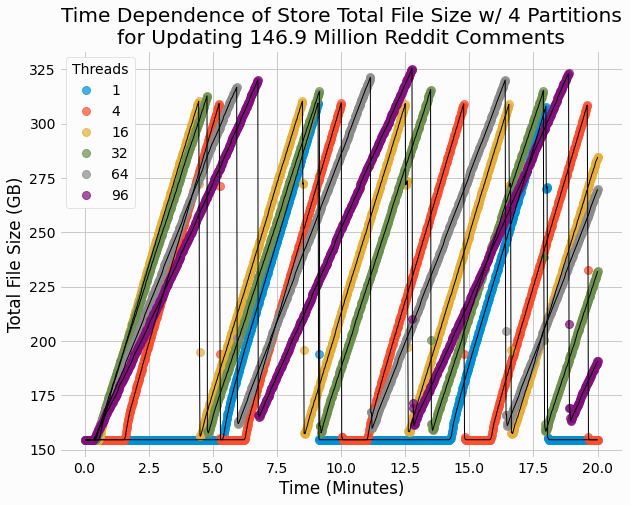

In [38]:
plt.figure(figsize=(9,7))

time_plot(update_results[(update_results['threads'].isin([1, 4, 16, 32, 64, 96])) &
                         (update_results['partitions'] == 4)]
          .sort_values('threads', ascending=True), 
          y_col='size', y_scale=1e-9, spline=False,
          label_func=lambda ix, row: str(row['threads']))

plt.ylabel('Total File Size (GB)')
plt.legend(loc='upper left', ncol=1, title='Threads', framealpha=1)
plt.xlabel('Time (Minutes)')
plt.title(f'Time Dependence of Store Total File Size w/ 4 Partitions'
          f'\nfor Updating {entries/1e6:.1f} Million Reddit Comments')
savefig('doc_update_time_dependence_size_threads')


<Figure size 648x504 with 0 Axes>

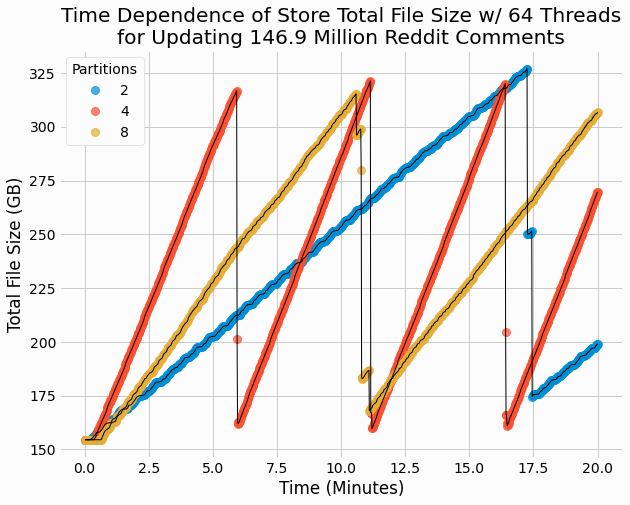

In [39]:

plt.figure(figsize=(9,7))

time_plot(update_results[(update_results['threads'] == 64)]
          .sort_values('partitions', ascending=True), 
          y_col='size', y_scale=1e-9, spline=False,
          label_func=lambda ix, row: str(row['partitions']))

plt.ylabel('Total File Size (GB)')
plt.legend(loc='upper left', ncol=1, title='Partitions', framealpha=1)
plt.xlabel('Time (Minutes)')
plt.title(f'Time Dependence of Store Total File Size w/ 64 Threads'
          f'\nfor Updating {entries/1e6:.1f} Million Reddit Comments')
savefig('doc_update_time_dependence_size_partitions')
